# Neural Network training PSO

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import pyswarms as ps

### Penguins dataset

The Penguins dataset is a popular dataset in the data science community that contains information on the size, sex, and species of penguins. 

The dataset consists of 344 observations collected from 3 islands in the Palmer Archipelago, Antarctica. It includes the following 7 variables:
* species: The species of penguin (Adelie, Chinstrap, or Gentoo).
* island: The island where the penguin was observed (Biscoe, Dream, or Torgersen).
* bill_length_mm: The length of the penguin's bill in millimeters.
* bill_depth_mm: The depth of the penguin's bill in millimeters.
* flipper_length_mm: The length of the penguin's flipper in millimeters.
* body_mass_g: The mass of the penguin's body in grams.
* sex: The sex of the penguin (male or female).

In [2]:
# Load the Penguins dataset
penguins = sns.load_dataset('penguins')
target_names = penguins.species.unique()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


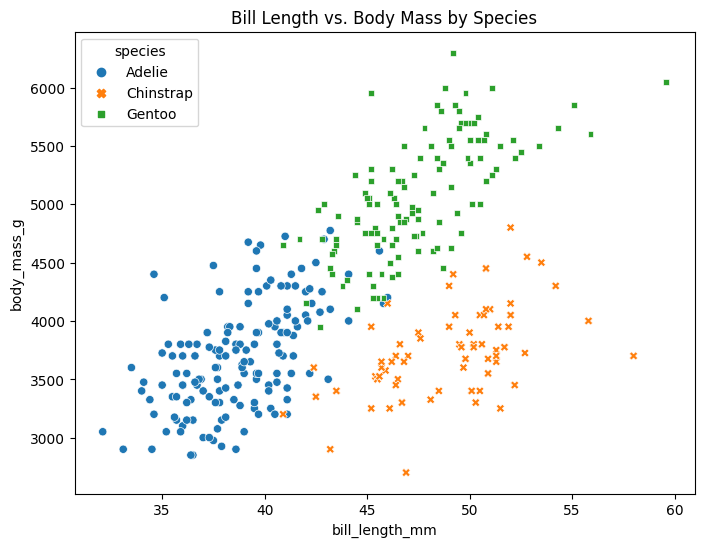

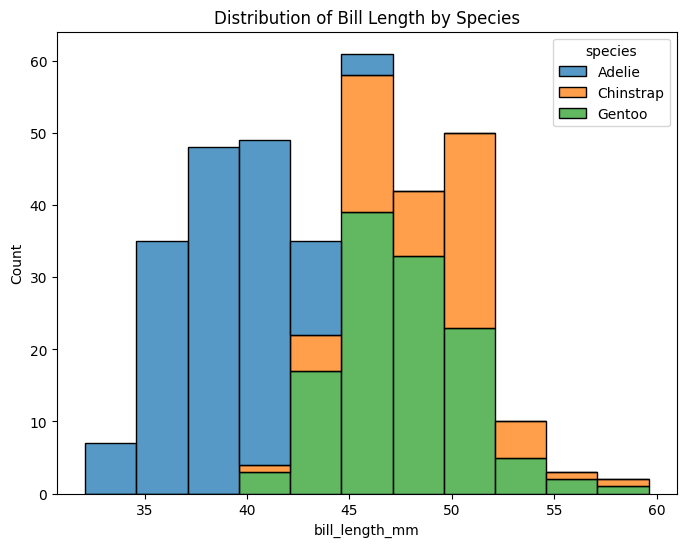

In [3]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=penguins, x='bill_length_mm', y='body_mass_g', hue='species', style="species")
plt.title('Bill Length vs. Body Mass by Species')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data=penguins, x='bill_length_mm', hue='species', multiple='stack')
plt.title('Distribution of Bill Length by Species')
plt.show()

In [4]:
# Preprocess the dataset
penguins = penguins.dropna()

X = penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']].to_numpy()
# X = penguins[['bill_length_mm', 'flipper_length_mm']].to_numpy() # use a reduced feature set
y = penguins['species'].to_numpy()

# Encode the target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

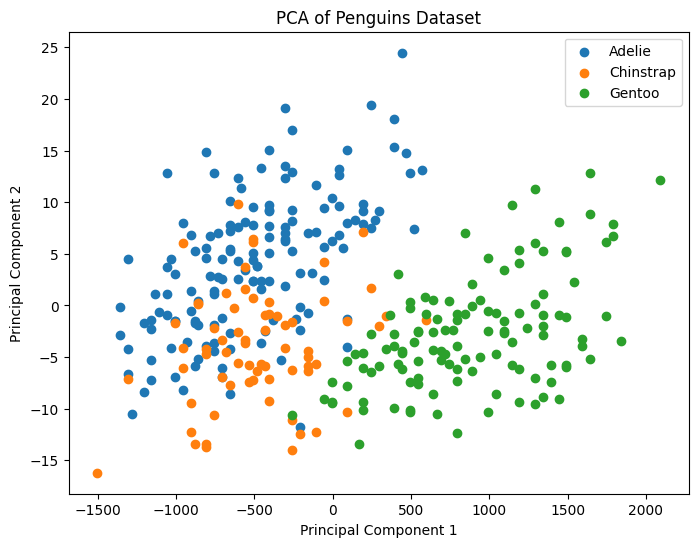

In [5]:
# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Plot the reduced dataset
plt.figure(figsize=(8, 6))
for i, target_name in enumerate(target_names):
    plt.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1], label=target_name)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('PCA of Penguins Dataset')
plt.show()

# Neural network architecture

In [6]:
n_inputs = X.shape[1]
n_classes = len(np.unique(y))
n_hidden = 10
num_samples = X.shape[0]

### Calculate roll-back the weights and biases

* Inputs: p: np.ndarray that represent an unrolled version of the weights and biases.
* Returns: numpy.ndarray of logits for layer 2

In [7]:
def logits_function(p):

    # Roll-back the weights and biases
    W1 = p[0: n_inputs * n_hidden].reshape((n_inputs, n_hidden))
    b1 = p[n_inputs * n_hidden: (n_inputs + 1) * n_hidden].reshape((n_hidden,))
    W2 = p[(n_inputs +1) * n_hidden: -n_classes].reshape((n_hidden, n_classes))
    b2 = p[-n_classes:].reshape((n_classes,))

    # Perform forward propagation
    z1 = X.dot(W1) + b1  # Pre-activation in Layer 1
    a1 = np.tanh(z1)     # Activation in Layer 1
    logits = a1.dot(W2) + b2 # Pre-activation in Layer 2
    return logits          # Logits for Layer 2

### Forward propagation as objective function

This function computes for the forward propagation of the neural network, as well as the loss.

* Inputs: params: np.ndarray. The dimensions should include an unrolled version of the weights and biases.
* Returns: the computed negative log-likelihood loss given the parameters

In [8]:

def forward_prop(params):

    logits = logits_function(params)

    # Compute for the softmax of the logits
    exp_scores = np.exp(logits)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Compute for the negative log likelihood

    corect_logprobs = -np.log(probs[range(num_samples), y])
    loss = np.sum(corect_logprobs) / num_samples

    return loss

### Forward propagation for the whole swarm

* Inputs: x: numpy.ndarray of shape (n_particles, dimensions) representing the swarm that will perform the search
* Returns: The computed loss for each particle

In [9]:
def f(x):
    n_particles = x.shape[0]
    j = [forward_prop(x[i]) for i in range(n_particles)]
    return np.array(j)

 ### Prediction

This function uses the trained weights to perform class predictions.

* Inputs: pos: numpy.ndarray. Position matrix found by the swarm. Will be rolled into weights and biases.
* Return: predicted class

In [10]:
def predict(pos):
    logits = logits_function(pos)
    y_pred = np.argmax(logits, axis=1)
    return y_pred

### Training NN using different PSO variants

In [11]:
# Set up the dimensions of the problem
dimensions = (n_inputs * n_hidden) + (n_hidden * n_classes) + n_hidden + n_classes

# Define the variants of PSO
PSO_varaints = ['globalBest', 'localBest', 'binaryPSO']

# Set-up PSO hyperparameters
# w: inertia parameter
# c1: cognitive parameter
# c2: social parameter,
# k: number of neighbors to be considered. Must be a positive integer less than n_particles
# p: the Minkowski p-norm to use. 1 is the sum-of-absolute values (or L1 distance) while 2 is the Euclidean (or L2) distance.
options = {'w':0.79, 'c1': 0.9, 'c2': 0.5, 'k': 8, 'p': 2}

# Traing NN using different variants of PSO and print the best accuracy
for algorithm in PSO_varaints:
    if algorithm == 'globalBest':
        optimizer = ps.single.GlobalBestPSO(n_particles=150, dimensions=dimensions, options=options)
        cost, pos = optimizer.optimize(f, iters=2000)
        print("#"*30)
        print(f"PSO varaints: {algorithm}")
        print(f"Best average accuracy: {100*round((predict(pos) == y).mean(),3)} %")
        print()
    elif algorithm == 'localBest':
        optimizer = ps.single.LocalBestPSO(n_particles=150, dimensions=dimensions, options=options)
        cost, pos = optimizer.optimize(f, iters=2000)
        print("#"*30)
        print(f"PSO varaints: {algorithm}")
        print(f"Best average accuracy: {100*round((predict(pos) == y).mean(),3)} %")
        print()
    elif algorithm == 'binaryPSO':
        optimizer = ps.discrete.BinaryPSO(n_particles=150, dimensions=dimensions, options=options)
        cost, pos = optimizer.optimize(f, iters=2000)
        print("#"*30)
        print(f"PSO varaints: {algorithm}")
        print(f"Best average accuracy: {100*round((predict(pos) == y).mean(),3)} %")
        print()

2023-04-26 18:53:43,305 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'w': 0.79, 'c1': 0.9, 'c2': 0.5, 'k': 8, 'p': 2}
pyswarms.single.global_best:  66%|██████▋   |1330/2000, best_cost=0.0156C:\Users\Alaa\AppData\Local\Temp\ipykernel_904\1591915119.py:6: RuntimeWarning: overflow encountered in exp
  exp_scores = np.exp(logits)
C:\Users\Alaa\AppData\Local\Temp\ipykernel_904\1591915119.py:7: RuntimeWarning: invalid value encountered in true_divide
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
pyswarms.single.global_best:  67%|██████▋   |1336/2000, best_cost=0.0156C:\Users\Alaa\AppData\Local\Temp\ipykernel_904\1591915119.py:11: RuntimeWarning: divide by zero encountered in log
  corect_logprobs = -np.log(probs[range(num_samples), y])
pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=0.0132
2023-04-26 18:55:31,955 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.013156304750788288, best pos: [-5.31239931e-

##############################
PSO varaints: globalBest
Best average accuracy: 99.7 %



pyswarms.single.local_best: 100%|██████████|2000/2000, best_cost=0.573
2023-04-26 18:57:21,255 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 0.5726255406714701, best pos: [ 1.22272202  1.27477574  0.84072025  0.92240794  1.13639708  0.54488949
  0.91762002  1.01218524  1.31843605  1.21948404  1.74744182  1.61371787
  1.49193254  2.42419021  0.91889369  1.44442283  1.1335797   1.16896612
  1.2219549   1.26374444  1.16553096  1.13350842  0.84341683 -0.20115873
  1.14351078  1.04627438  1.38487     0.65851219  1.29098197  1.03696442
  1.2492723   1.58517775  1.38159432 -0.00906175  1.468061    0.73897121
  1.21085084  0.56883023  1.47135588  0.99380781  0.52956467  1.5901082
  0.17463145  1.51872127  1.69183938  1.84973466  1.54082125  1.07803292
  1.24082921  1.40492788  1.00744934  0.79298486  1.00795172  0.933281
  0.77917472  1.07644712  1.22743141  1.03273515  0.90260415  1.14922936
  1.54924097 -0.40622943  0.28505217  0.86766092  0.9211141   1.04561813
  

##############################
PSO varaints: localBest
Best average accuracy: 79.60000000000001 %



pyswarms.discrete.binary: 100%|██████████|2000/2000, best_cost=1.05
2023-04-26 18:59:31,103 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 1.0537800202076317, best pos: [0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0
 0 1 0 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1
 1 0 0 0 0 1 1 1 0]


##############################
PSO varaints: binaryPSO
Best average accuracy: 43.8 %

